This python notebook was prepared for the interview: <b> Data Scientist (KTP Associate) at Process Integration Ltd.</b>

The following task was requested:

<i> Please find attached a CSV file with readings from a flow meter in a large petrochemicals production plant. It is only one of many sensors that are available. The readings are taken once per minute. Flow meters tend to return quite noisy measurements and occasionally they return nonsensical values (outliers). We are interested in determining the steady states of operation, because ultimately we want to use these steady states to build a machine learning model of the plant using only sensor measurements. <p>

Please use Python to explore the data and produce a 10 minute presentation. Focus on one of the following data tasks: noise level estimation, smoothing, outlier detection, or steady state detection. Implement your method in Python and present your approach and findings to a mixed team of Chemical Engineers, Mathematicians, and Computer Scientists.

This python code was prepared and executed on IBM Cloud, with embedded IBM Watson Studio (up to 4GB RAM memory).


### Why did I apply for this position? - My intentions and background
Hello,
My name is Kamil and I am a researcher-scientist with a background in Chemistry/Physical Chemistry and PhD in Chemical Engineering. And this is about me and why I am interested in the above position.

Knowledge Transfer Partnerships (KTP) is a great idea - it allows people like me to taste working in industry, and still being a part of academia, whilst evolving in both of these areas at the same time (also - as UoM staff you get access to so many databases!). It usually comes with a fund for the associate which can be used for training, conferences, <i> etc.</i> I, personally,  recently have been looking to more dynamic, product-oriented environment - such as those offered by industry, and needless to say a new challenge! Moreover, I am fascinated with the possibilities data science, or generally computer science, can offer us (even though I curse it everyday scrolling down my internet pages and having to look at all the <i>tailored</i> adverts!).<p>
One could say it all sounds great (and cliché). But what are my true intentions for applying for this position?<p>
    
I have been doing research for the last 6 or so (you really lose count after some time!) years. During my PhD I had the chance to work with Prof. Johan Jacquemin who is a specialist in equations of state, data analysis and modelling for chemistry/chemical engineering purposes. Thus, a natural course of progression was to do some modelling. Because my PhD was focused on thermophysical properties of ionic liquid - based nanofluids (basically a liquid mixed with nanoparticles), I did some predictive modelling of these thermophysical properties for pure ionic liquids (and some regression models for the mixtures). From the quantum chemical calculations, I have redefined the parameters of the most plausible model by adding charge distribution on the molecule parameters. I was able to reduce the error from 12.57% to 4.28% (average absolute relative deviation, which is really good in the prediction of thermophysical properties!). For the last year, I have been predicting mutual solubility of liquids, hydrogen bonding affinity. And whilst this was my day-to-day minor tasks, it did not satisfy my craving for data science so in my spare time I have been working on finding a correlation between coordination parameter and thermophysical properties of organic liquids through kNN in Python, and learning more about data science.<p>

I am an excellent researcher - which was highlighted by awarding me two prizes for contribution to thermal sciences. And while I am no mathematician nor computer scientist, I am highly motivated and intelligent scientist with willingness to learn more and more. This position will allow me to work in completely different and challenging environment (with mathematicians, computer scientists, industry) and a new subject that I am sure I will excel should I be given the opportunity.
    
### Theoretical background behind this task
    
The data tasks discussed herein is steady-state detection.
    
Steady-state conditions: <i> statistical properties of a process generating data (i.e. time series) do not change as a function of time.</i> It is important to know whether the investigated time series is steady-state or not, due to implications in further modelling and analysis. Thus, detecting it in a chemical process and using for modelling.
    
Non-stationary time series can be divided into the following groups:
    1. Random walk: value at time t is equal to the value at t-1 and some stochastic (non-systematic) white noise et: Yt = Yt-1 + et, with et of average equal to 0 and variance s2. The variance is time-dependent, increasing to infinity - thus, random walk cannot be predicted. 
    2. Trend (+ Random walk/+Cycle) - A deterministic trend can also include cycle or random walk. In case of random walk the the value at t is regressed on the last period's value Yt-1, whilst for deterministic trend it is regressed on a time trend Bt. The deterministic trend has a mean that grows with a constant and time-independent trend. 
    3. Cycle

There is a few steps that can help investigate stationarity of investigated time series:
    1. Basic statistics, involving average, number of data points, upper/lower quartiles and median, can provide the very first insight into understanding the data. Particularly the number of data points will give an idea of how long the calculations might take. Average and median are two basic parameters for distribution of the data. Generally, average and mean of the same/similar values indicate on normal distribution. If average > median - positive/right nonparametric skew, otherwise negative/left nonparametric skew. Quartiles are very useful to determine outliers within the data set.
    2. Histogram, shows a distribution of the values in the time series divided between set bins number. It can confirm the preliminary results from basic statistics (i.e. normality), and visualise and abnormalities. 
    3. Visual/qualitative inspection of the plot of studied time series. A general information can be drawn, for example any visible trends, impact of white noise, some of the outliers.
    4. There a few tests (which are also available in Python) that allow searching for stationarity in the investigated time series:
![alt text](https://raw.githubusercontent.com/kamiloster/Data_Scientist_Interview/master/Tests.PNG "Logo Title Text 1")
    
    5. Lag_plot can visualise the randomness of the data.

In [4]:
# Reading all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import norm
from statsmodels.tsa.stattools import acf,pacf

# Importing data from GitHub
df=pd.read_csv('https://raw.githubusercontent.com/kamiloster/Data_Scientist_Interview/master/data.csv', header=None, names=['Flow'])

#--------------------------------
# Approach 1 - on the entire dataset
#--------------------------------

# Basic statistics
df.describe()

,Flow
count,131039.000000
mean,33.367791
std,2.913794
min,0.000000
25%,31.138000
50%,33.193000
75%,35.646000
max,56.223000


Generally, the data set is quite substantial - over 130k data points. 
The average value of the flow reading over the whole set is 33.4 with standard deviation of 2.9. 
Clearly, the data set contains outliers - minimum value of 0 and maximum of 56.22. 
Mean and median have similar values (33.4 and 33.2, respectively) indicating on the symmetrical distribution.

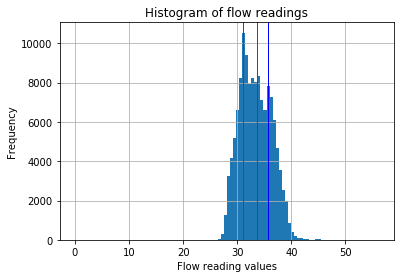

In [147]:
df.hist(bins=100)
plt.title('Histogram of flow readings') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Flow reading values') # add x-label
plt.axvline(x=31, linewidth=1, color='r')
plt.axvline(x=33.6, linewidth=1, color='g')
plt.axvline(x=35.7, linewidth=1, color='b')
plt.show()

A quick look at the histagram can show that despite similar median and average values of the whole dataset, the histogram is ill-symmetrical. Moreover, very qualitatively, three centres can be distinguished: </p>

(i) at flow meter reading 31 (red) </p>

(ii) at flow meter reading 33.8 (green) </p>

(iii) at flow meter reading 35.7 (blue)

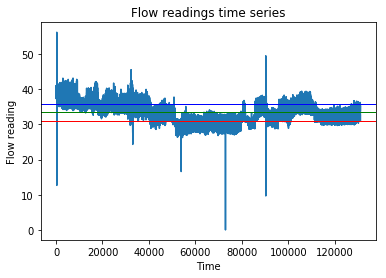

In [148]:
# Plotting flow meter reading(time)
plt.plot(df)
plt.xlabel('Time')
plt.ylabel('Flow meter reading')
plt.title('Flow readings time series')
plt.axhline(y=31, linewidth=1, color='r')
plt.axhline(y=33.6, linewidth=1, color='g')
plt.axhline(y=35.7, linewidth=1, color='b')

plt.show()

Plotting the graph of flow meter reading(time) shows some dependencies of the flow reading over time: </p>
    
(i) <38k minutes consistent decrease of flow reading values; </p>

(ii) >38k & <50k visibly constant values (green on histogram); </p>

(ii) >50k & <80k after abrupt decrease, visibly constant values (red on histogram); </p>

(iii) >80k & <110k consistent increase of flow reading values; </p>

(iv) >110k visibly constant values (green on histogram)

Blue line present in the histogram, and translated into the flow readin(time) plot, is probably related to some short-time stationary conditions which are difficult to detect visually.

In [149]:
# Statistical test: Augmented Dickey-Fuller (adfuller) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

X_adf = df.iloc[:,0].values
result_adf = adfuller(X_adf, regression='ct')
result_kpss=kpss(X_adf, regression='ct')

print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
	print('\t%s: %.3f' % (key, value))
    
print('KPS test statistics %f' %result_kpss[0])
print('p-value: %f' %result_kpss[1])
print('Truncation lag parameter: %f' %result_kpss[2])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.4f' % (key, value))
    
print(f'Result of ADF test: The series is {"not " if result_adf[1] > 0.05 else ""}stationary')
print(f'Result of KPSS test: The series is {"not " if result_kpss[1] < 0.05 else ""}stationary')

ADF Statistic: -7.973630
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.411
	10%: -3.127
KPS test statistics 26.427089
p-value: 0.010000
Truncation lag parameter: 73.000000
Critical Values:
	10%: 0.1190
	5%: 0.1460
	2.5%: 0.1760
	1%: 0.2160
Result of ADF test: The series is stationary
Result of KPSS test: The series is not stationary


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


As can be seen, the statistical results produced contradictory results, i.e. ADF showed the time series is stationary, and KPSS that the time series is not stationary. As proved by authors of KPSS, the time series can have no root and still be non-stationary. Plotting lag_plot can provide information whether the time series has some patterns.

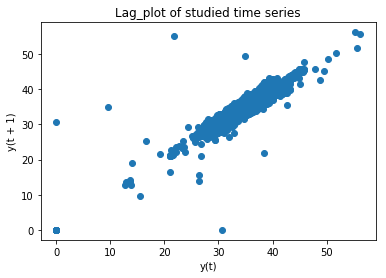

In [155]:
pd.plotting.lag_plot(df)
plt.title('Lag_plot of studied time series')
plt.show()

In the plot above, it can be seen that there is a linear correlation in the lag_plot, indicating that the data in time series are not random. For further time series modelling, strong autocorrelation or autoregressive models would be advised.

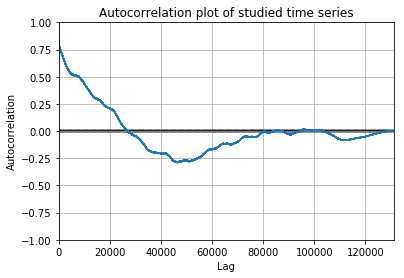

In [158]:
pd.plotting.autocorrelation_plot(df)
plt.title('Autocorrelation plot of studied time series')
plt.show()

Autocorrelation plot shows randomness in the data. Data in the time series that are non-random have +/- autocorrelation values, whilst random ones are near 0. The horizontal lines also show 95% and 99% confidence bands, and dashed line 99% confidence.

Future perspectives for this project:
    1. The flow meter reading seems to produce a lot of white noise, which can be a defect from the apparatus, or in case of large chemical reactors, random fluctuations in the flow (which can be also affected by many factors, such as pressure, temperature, density, etc.). Estimating the noise level would definitely benefit this project. Perhaps, smoothing the data would help further modelling, and assessing the stationarity as level of white noise would affect the time series.
    2. Clearly, the time series contains outliers (which can be seen in the basic statistics, plotting the flow meter readings against time, or lag_plot). Removing them would improve the statistical tests for stationarity.
    3. Non-stationary data can be made stationary by differencing method, used for forecasting.

In [160]:
#--------------------------------
# Approach 1 - continuous reading
#--------------------------------

In my previous postdoctoral position, I designed, built and optimised an apparatus for measurement of thermal conductivity (currently under review for publication). One of the main components of the equipment was a data acquisition system that measured the temperature readings from 4 thermocouples. This allowed us to control the temperature of the environment, sample, coolant and reference. The major task was to put together a software that would automate the measurement. This has been done in LabVIEW, (there was issues with coupling the National Instruments data acquisition system and python) and python script was prepared for analysis of the data.
![alt text](https://raw.githubusercontent.com/kamiloster/Data_Scientist_Interview/master/image.png "Logo Title Text 1")

The software is reading all 4 thermocouples, waiting for the system to stabilise (i.e. temperature fluctuation below the previously ascertained threshold, determined experimentally), and starting the measurement procedure and return the results of analysis.

Similar approach is proposed for this project. Whilst the whole time series will enable modelling of the chemical reactor, or process, to control the process, detection of stationary conditions in continuously reading the flow meter is essential.

Since ADF produces results that do not indicate stationary conditions per se, KPSS test will be used for this purpose. Stationary conditionsare taken with every 30 minutes and 60 minutes, to compare the effect of stabilisation time (shifting with 1 minute window). To speed up the calculations, data were reduced by factor 10.

In [5]:
# 60 minutes stabilisation
y_cont1=[]
df2=df['Flow']
test_result1=[]
for i in range(0,len(df2), 10):
    y_cont1.append(df2[i])
    if len(y_cont1) < 10:
        pass
    elif len(y_cont1) >= 10 and len(y_cont1) <= 60:
        y_cont_test1=pd.DataFrame(y_cont1).iloc[:,0].values
        result_kpss21 = kpss(y_cont_test1, regression='ct')
        if result_kpss21[1] <= 0.05:
            test_result1.append(0)
        else:
            test_result1.append(1)
    else:
        y_cont_test1=pd.DataFrame(y_cont1).tail(60).iloc[:,0].values
        result_kpss21 = kpss(y_cont_test1, regression='ct')
        if result_kpss21[1] >= 0.05:
            test_result1.append(1)
        else:
            test_result1.append(0)

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

In [6]:
# 30 minutes stabilisation
y_cont2=[]
df2=df['Flow']
test_result2=[]
for i in range(0,len(df2), 10):
    y_cont2.append(df2[i])
    if len(y_cont2) < 10:
        pass
    elif len(y_cont2) >= 10 and len(y_cont2) <= 30:
        y_cont_test2=pd.DataFrame(y_cont2).iloc[:,0].values
        result_kpss22 = kpss(y_cont_test2, regression='ct')
        if result_kpss22[1] <= 0.05:
            test_result2.append(0)
        else:
            test_result2.append(1)
    else:
        y_cont_test2=pd.DataFrame(y_cont2).tail(30).iloc[:,0].values
        result_kpss22 = kpss(y_cont_test2, regression='ct')
        if result_kpss22[1] >= 0.05:
            test_result2.append(1)
        else:
            test_result2.append(0)

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels

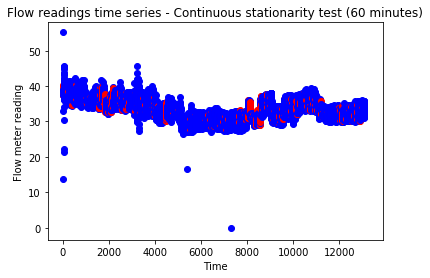

In [14]:
for i in range(10, len(y_cont1)-10):
    colors=['blue' if test_result1[i] == 1 else 'red']
    plt.scatter(i, y_cont1[i], color=colors)
    
plt.xlabel('Time')
plt.ylabel('Flow meter reading')
plt.title('Flow readings time series - Continuous stationarity test (60 minutes)')
plt.show()

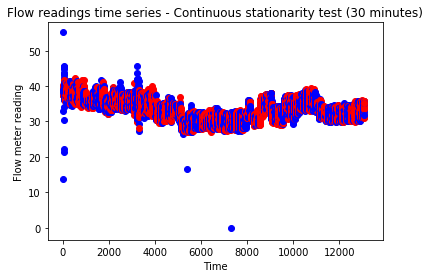

In [15]:
for i in range(10, len(y_cont2)-10):
    colors=['blue' if test_result2[i] == 1 else 'red']
    plt.scatter(i, y_cont2[i], color=colors)
    
plt.xlabel('Time')
plt.ylabel('Flow meter reading')
plt.title('Flow readings time series - Continuous stationarity test (30 minutes)')
plt.show()

Based on the above graphs, it can be seen that the time taken for the stability test has a significant effect. For shorter time, it is impossible to distinguish a stationary conditions, however, for 60 minutes range it is stationary in almost the whole set. To make it possible for the data to distinguish regions of stationarity, these should be smoothed. A better coefficient to consider in terms of stationarity would probably the error induced by noise.